In [1]:
import sys
sys.path.append("../")

from src.common_functions import *

In [2]:
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import sys
import pandas as pd

In [3]:
RAW_DATA_PATH = "../datasets/churn/e_commerce_churn.xlsx"
DATASET_NAME = Path(RAW_DATA_PATH).stem
df = pd.read_excel(RAW_DATA_PATH, sheet_name="E Comm")
df = df.rename(columns=dict(
    zip(df.columns, list(map(to_snake_case, df.columns)))))

print(df.shape[0])
df.churn.value_counts()/df.shape[0]*100

5630


churn
0    83.161634
1    16.838366
Name: count, dtype: float64

In [4]:
df.isna().any()

customer_id                        False
churn                              False
tenure                              True
preferred_login_device             False
city_tier                          False
warehouse_to_home                   True
preferred_payment_mode             False
gender                             False
hour_spend_on_app                   True
number_of_device_registered        False
prefered_order_cat                 False
satisfaction_score                 False
marital_status                     False
number_of_address                  False
complain                           False
order_amount_hike_fromlast_year     True
coupon_used                         True
order_count                         True
day_since_last_order                True
cashback_amount                    False
dtype: bool

In [5]:
y = "churn"

# some generic cleaning

COLUMNS_TO_DROP = []
assert df[y].isna().any() == False
raw_features = df.drop(COLUMNS_TO_DROP, axis=1)

# ML tuning

train, test = train_test_split(
    raw_features, test_size=0.2, random_state=0, stratify=df[y])

fit_le = LabelEncoder().fit(train[y])

In [6]:
param_grid = {
    'logistic__penalty': ['l2'],
    'logistic__C': [1, 10, 100, 1000],
    'pca__n_components': list(range(6, 32, 4)),
    'under__sampling_strategy': [0.1, 0.2, 0.3, 0.5, 0.7, 1],
    'over__sampling_strategy': [0.2, 0.3, 0.4, 0.5, 0.7, 1]
}

model = LogisticRegression()

MODEL_NAME = 'logistic'

grid = sklearn_gridsearch_using_pipeline(
    train, y_col_name=y, model=model, fit_le=fit_le, model_name='logistic', param_grid=param_grid)
best_pipeline_log_reg = grid.best_estimator_
best_pipeline_log_reg

Fitting 5 folds for each of 1008 candidates, totalling 5040 fits


/home/maarten/.local/share/virtualenvs/End-to-end-project---Customer-churn-PLUo0CZ0/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
4060 fits failed out of a total of 5040.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1680 fits failed with the following error:
Traceback (most recent call last):
  File "/home/maarten/.local/share/virtualenvs/End-to-end-project---Customer-churn-PLUo0CZ0/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/maarten/.local/share/virtualenvs/End-to-end-project---Customer-churn-PLUo0CZ0/lib/python3.11/site-packages/imblearn/pipeline.py", line 293, in fit
   

Best score: 0.8902554282903521
Best parameters: {'logistic__C': 1000, 'logistic__penalty': 'l2', 'over__sampling_strategy': 0.4, 'pca__n_components': 30, 'under__sampling_strategy': 0.3}


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['customer_id', 'tenure',
                                                   'city_tier',
                                                   'warehouse_to_home',
                                                   'hour_spend_on_app',
                                                   'number_of_device_registered',
                                                   'satisfaction_score',
                                                   'number_of_address',
                                                   'complain',
                                                   'order_amount_hike_fromlas...
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(sparse_output=False))]),
                                                  ['preferred_login_device',
                                                   'preferred_payment_mode',
                                                   'gender',
                                                   'prefered_order_cat',
                                                   'marital_status'])])),
                ('under', RandomUnderSampler(sampling_strategy=0.3)),
                ('over', SMOTE(sampling_strategy=0.4)),
                ('pca', PCA(n_components=30)),
                ('logistic', LogisticRegression(C=1000))])

In [7]:
write_pipeline(best_pipeline_log_reg, MODEL_NAME, DATASET_NAME)

In [8]:
COLUMNS = ["under__sampling_strategy", "over__sampling_strategy", "pca__n_components", f"{MODEL_NAME}__C", f"{MODEL_NAME}__penalty", "roc_auc_mean", "roc_auc_std"]

pd.concat([
    pd.DataFrame(grid.cv_results_["params"]),
    pd.DataFrame(grid.cv_results_["mean_test_score"], columns=["roc_auc_mean"]),
    pd.DataFrame(grid.cv_results_["std_test_score"], columns=["roc_auc_std"])
    ],axis=1).dropna(subset=["roc_auc_mean", "roc_auc_std"])[COLUMNS].sort_values(by=COLUMNS)

,under__sampling_strategy,over__sampling_strategy,pca__n_components,logistic__C,logistic__penalty,roc_auc_mean,roc_auc_std
86,0.3,0.4,6,1,l2,0.771602,0.012335
338,0.3,0.4,6,10,l2,0.773047,0.007295
590,0.3,0.4,6,100,l2,0.785651,0.013562
842,0.3,0.4,6,1000,l2,0.776692,0.012627
92,0.3,0.4,10,1,l2,0.853447,0.011090
...,...,...,...,...,...,...,...
1000,0.7,1.0,26,1000,l2,0.887135,0.013269
250,0.7,1.0,30,1,l2,0.886445,0.011218
502,0.7,1.0,30,10,l2,0.886422,0.011013
754,0.7,1.0,30,100,l2,0.887074,0.012090


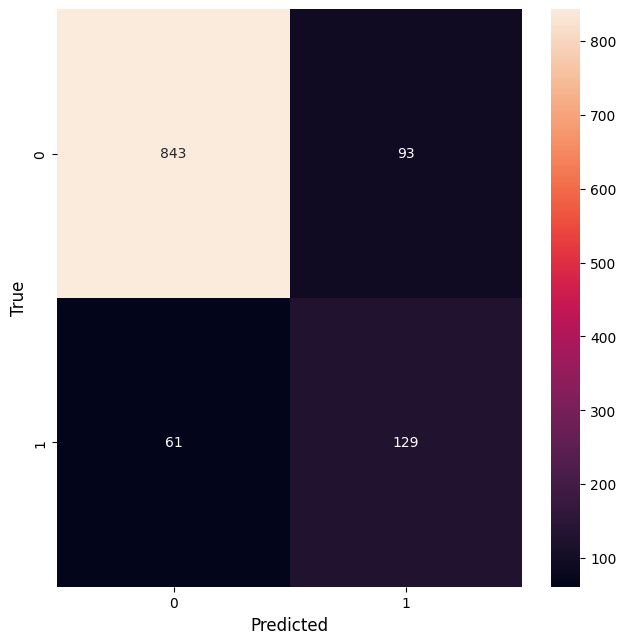

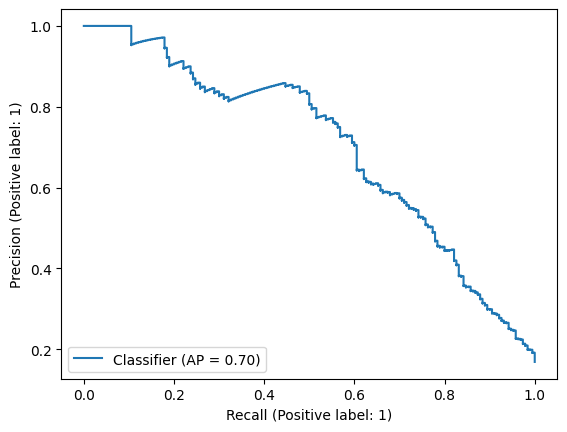

In [9]:
evaluate_model(best_pipeline_log_reg, fit_le=fit_le, test=test, y_col_name=y)

## Cost-based evaluation

In [70]:
# Step 2: Define a function to calculate the instance-dependent cost
def instance_dependent_cost(prediction: int, encoded_true_label: int, a: float) -> float:
    """
    Calculates the instance-dependent cost for a single instance.

    Parameters
    ----------
    prediction : int
        The predicted label.
    encoded_true_label : int
        The true label.
    a : float
        The cost of a false positive.

    Returns
    -------
    float
        The instance-dependent cost.
    """
    if encoded_true_label == 1 and prediction == 1:  # True Positive (TP)
        return 0
    elif encoded_true_label == 0 and prediction == 1:  # False Positive (FP)
        return 2 * a
    elif encoded_true_label == 0 and prediction == 0:  # True Negative (TN)0
        return 0
    elif encoded_true_label == 1 and prediction == 0:  # False Negative (FN)
        return 12 * a

test_predictions = test.copy(deep=True)
test_predictions["y_predicted"] = best_pipeline_log_reg.predict(test_predictions.drop(y, axis=1))
test_predictions["churn_encoded"] = fit_le.transform(test_predictions["churn"])

# first check if customers have multiple rows => if so check if we can take other if this instance-based cost
impute = SimpleImputer(strategy='median')
test_predictions['A'] = impute.fit_transform(
    (test_predictions["order_count"]*test_predictions["tenure"]).to_frame())[:, 0]

# Step 3: Apply the function to calculate the cost for each instance and create the instance-dependent cost matrix
test_predictions['instance_cost'] = test_predictions.apply(lambda row: instance_dependent_cost(
    row['y_predicted'], row["churn_encoded"], row["A"]), axis=1)

test_predictions["y_predicted_decoded"] = fit_le.inverse_transform(
    test_predictions["y_predicted"])

# Print the DataFrame with the instance-dependent cost matrix
test_predictions[['churn', 'y_predicted_decoded', "A", 'instance_cost']]

print(f"Test cost/loss = {test_predictions['instance_cost'].sum():.0f}.")

Test cost/loss = 24288.
